In [46]:
import json
import warnings
from itertools import product
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.time import Time
from sherpa.astro.io import read_arf, read_rmf
from sherpa.astro.instrument import RSPModelNoPHA
from sherpa.astro.utils import calc_model_sum
from sherpa.astro.xspec import XSpowerlaw, XSphabs, XSTBabs, XSwabs
from sherpa.utils.logging import SherpaVerbosity

plt.style.use("Solarize_Light2")


def calc_ecf(rsp_model, elo, ehi, abscorr=False):
    rate = rsp_model(0)

    if abscorr:
        flux_model = rsp_model.model.parts[1]
    else:
        flux_model = rsp_model.model

    e = 0.5 * (rsp_model.rmf.e_min + rsp_model.rmf.e_max)
    flux = e * flux_model(rsp_model.rmf.e_min, rsp_model.rmf.e_max) << u.keV / u.s / u.cm**2 
    flux = flux.to(u.erg / u.s / u.cm**2).value
    
    mask_eband = np.logical_and(rsp_model.rmf.e_min >= elo, rsp_model.rmf.e_max <= ehi)
    
    return rate[mask_eband].sum() / flux[mask_eband].sum() / 1e11


ebands = {
    0: (0.3, 10.0),
    1: (0.3, 1.0),
    2: (1.0, 2.0),
    3: (2.0, 10.0),
    "SOFT": (0.5, 2.0),
    "HARD": (2.0, 10.0),
}

epochs = {
    "e1": ("2004-12-01", "2007-01-01"),
    "e2": ("2007-01-01", "2007-08-31"),
    "e3": ("2007-08-31", "2009-01-01"),
    "e4": ("2009-01-01", "2011-01-01"),
    "e5": ("2011-01-01", "2013-01-01"),
    "e6": ("2013-01-01", "2013-12-12"),
    "e7": ("2013-12-12", "2021-01-01"),
    "e8": ("2021-01-01", None),
}

modes = ("wt", "pc")

wt_grades = ("0", "02")
pc_grades = ("0", "04", "012")

data_path = Path("data", "swift")

In [15]:
# Source model, as in Rossen+2016
po = XSpowerlaw("po")
po.PhoIndex = 1.7

galabs = XSphabs("galabs")
# galabs = XSwabs("galabs")
# galabs = XSTBabs("galabs")
galabs.nH = 3e20 / 1e22

model = galabs * po

In [16]:
arfs_path = data_path / "arfs"
rmfs_path = data_path / "rmfs"

lognhs = np.linspace(19, 22, num=31)
gammas = np.linspace(1.4, 2.2, num=9)

ecf = {
    "lognh": lognhs.tolist(),
    "gamma": gammas.tolist(),
}
for mode in modes:
    ecf[mode] = {}

    if mode == "wt":
        grades = wt_grades
    else:
        grades = pc_grades
        
    for epoch in epochs:
        ecf[mode][epoch] = {}

        if epoch in ["e1", "e2"]:
            arf_filename = str(arfs_path / f"xrt_s0.arf")
        else:
            arf_filename = str(arfs_path / f"xrt_s6.arf")

        with SherpaVerbosity("ERROR"):
             read_arf(arf_filename)

        for grade in grades:
            ecf[mode][epoch][grade] = {}

            with SherpaVerbosity("ERROR"):
                rmf = read_rmf(str(rmfs_path / f"xrt_{epoch}_{mode}_{grade}.rmf"))
                rsp_model = RSPModelNoPHA(arf, rmf, model)

            for eband, (elo, ehi) in ebands.items():
                print(mode, epoch, grade, eband, end="\r")                
                ecf[mode][epoch][grade][eband] = {}

                model_ecfs = []
                for lognh, gamma in product(lognhs, gammas):
                    rsp_model.pars[0].val = 10**lognh / 1e22
                    rsp_model.pars[1].val = gamma

                    model_ecfs.append(calc_ecf(rsp_model, elo, ehi))

                ecf[mode][epoch][grade][eband] = np.reshape(model_ecfs, (len(lognhs), len(gammas))).tolist()


with open(data_path / "ecfs.json", "w") as fp:
    json.dump(ecf, fp, indent=4)

/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s0.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e1_wt_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e1_wt_02.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s0.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e2_wt_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e2_wt_02.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e3_wt_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e3_wt_02.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e4_wt_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e4_wt_02.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e5_wt_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e5_wt_02.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e6_wt_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e6_wt_02.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e7_wt_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e7_wt_02.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e8_wt_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e8_wt_02.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s0.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e1_pc_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e1_pc_04.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e1_pc_012.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s0.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e2_pc_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e2_pc_04.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e2_pc_012.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e3_pc_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e3_pc_04.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e3_pc_012.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e4_pc_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e4_pc_04.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e4_pc_012.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e5_pc_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e5_pc_04.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e5_pc_012.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e6_pc_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e6_pc_04.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e6_pc_012.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e7_pc_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e7_pc_04.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e7_pc_012.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/swift/arfs/xrt_s6.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e8_pc_0.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e8_pc_04.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/swift/rmfs/xrt_e8_pc_012.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


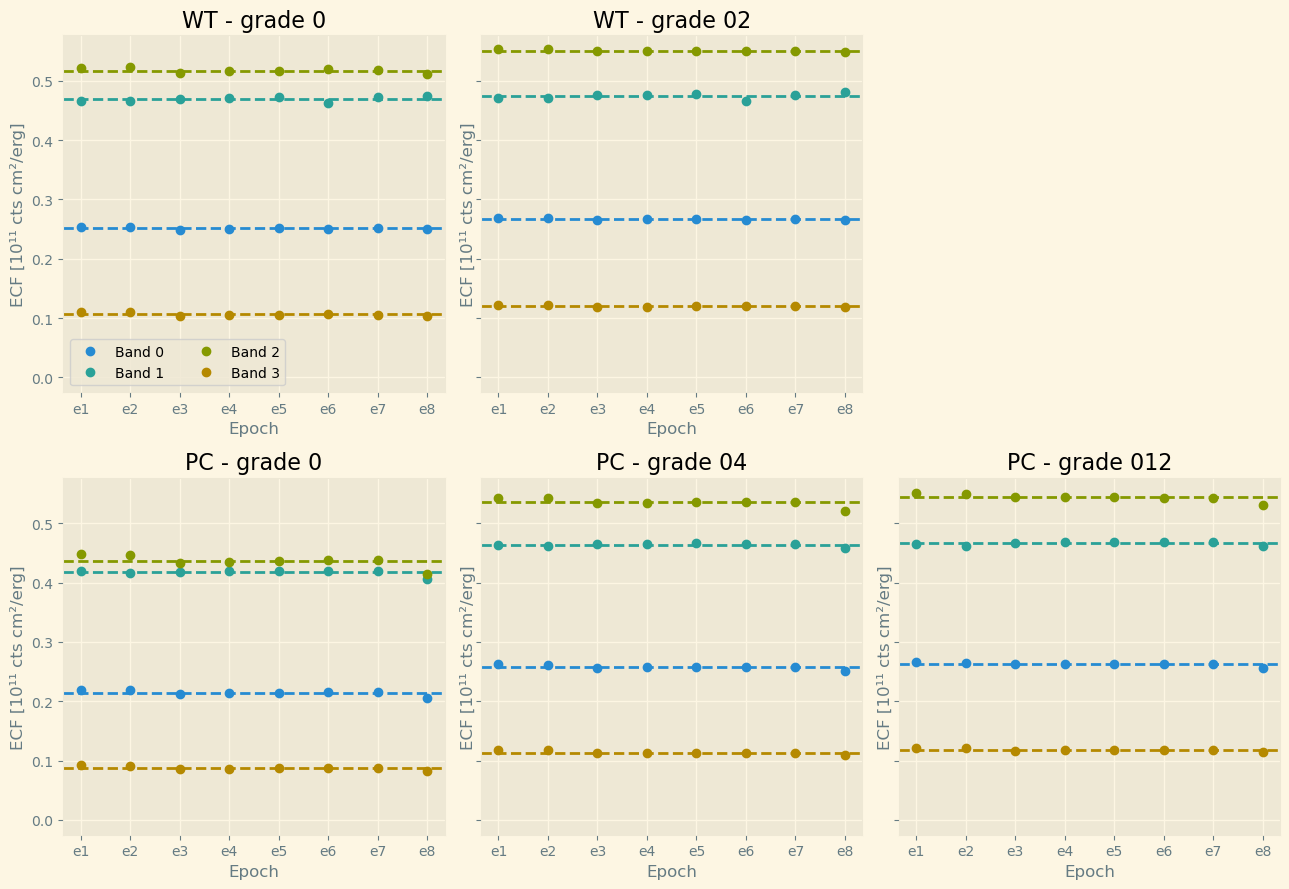

In [41]:
idx_lognh = 15  # ~3e20
idx_gamma = 3   # 1.7


fig, axes = plt.subplots(2, 3, figsize=(13,9), sharey=True)

ax = None
for i, mode in enumerate(modes):
    if mode == "wt":
        grades = wt_grades
    else:
        grades = pc_grades
    
    for j, grade in enumerate(grades):
        axes[i, j].set_title(f"{mode.upper()} - grade {grade}")
    
        for eband in range(4):
            cecf = [ecf[mode][epoch][grade][eband][idx_lognh][idx_gamma] for epoch in epochs]
            vals, = axes[i, j].plot(epochs.keys(), cecf, "o", label=f"Band {eband}")
            axes[i, j].axhline(np.mean(cecf), ls="--", color=vals.get_color())
    
            # max_diff = np.max(cecf) - np.min(cecf)
            # print(mode, eband, 100*np.std(cecf)/np.mean(cecf), 100*max_diff/np.mean(cecf))
    
        axes[i, j].set_xlabel("Epoch")
        axes[i, j].set_ylabel("ECF [10¹¹ cts cm²/erg]")

axes[0, 0].legend(ncol=2)
axes[0, 0].set_ylim(-0.025)
axes[0, 2].set_axis_off()

plt.tight_layout()
plt.show()

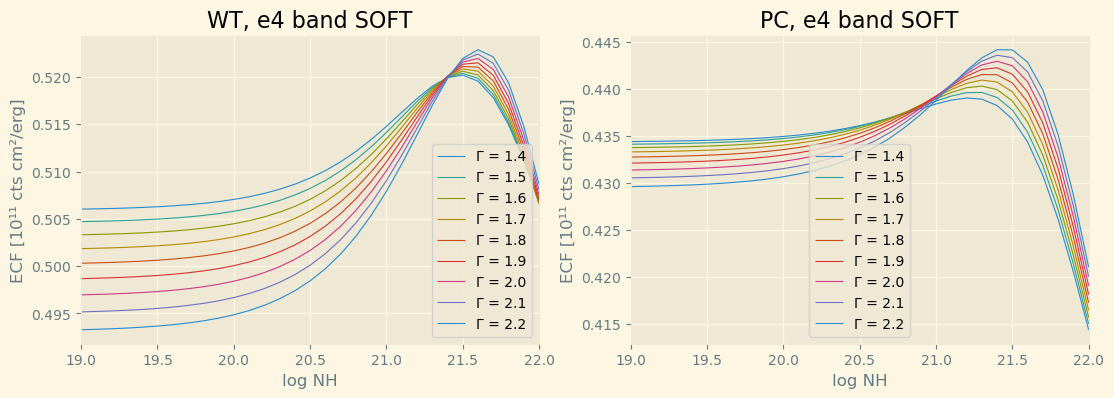

In [57]:
band = "SOFT"

plt.figure(figsize=(13,4))

plt.subplot(121)
plt.title(f"WT, e4 band {band}")

for i, gamma in enumerate(ecf["gamma"]):
    cecf = [ecf["wt"]["e4"]["0"][band][idx_lognh][i] for idx_lognh, _ in enumerate(ecf["lognh"])]
    plt.plot(ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")

plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")


plt.subplot(122)
plt.title(f"PC, e4 band {band}")

for i, gamma in enumerate(ecf["gamma"]):
    cecf = [ecf["pc"]["e4"]["0"][band][idx_lognh][i] for idx_lognh, _ in enumerate(ecf["lognh"])]
    plt.plot(ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")

plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")

plt.show()

In [60]:
arfs_path = data_path / "arfs"
rmfs_path = data_path / "rmfs"

lognhs = np.linspace(19, 22, num=31)
gammas = np.linspace(1.4, 2.2, num=9)

abscorr_ecf = {
    "lognh": lognhs.tolist(),
    "gamma": gammas.tolist(),
}
for mode in modes:
    abscorr_ecf[mode] = {}

    if mode == "wt":
        grades = wt_grades
    else:
        grades = pc_grades
        
    for epoch in epochs:
        abscorr_ecf[mode][epoch] = {}

        if epoch in ["e1", "e2"]:
            arf_filename = str(arfs_path / f"xrt_s0.arf")
        else:
            arf_filename = str(arfs_path / f"xrt_s6.arf")

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            read_arf(arf_filename)

        for grade in grades:
            abscorr_ecf[mode][epoch][grade] = {}

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                rmf = read_rmf(str(rmfs_path / f"xrt_{epoch}_{mode}_{grade}.rmf"))
                
            rsp_model = RSPModelNoPHA(arf, rmf, model)

            for eband, (elo, ehi) in ebands.items():
                print(mode, epoch, grade, eband, end="\r")                
                abscorr_ecf[mode][epoch][grade][eband] = {}

                model_ecfs = []
                for lognh, gamma in product(lognhs, gammas):
                    rsp_model.pars[0].val = 10**lognh / 1e22
                    rsp_model.pars[1].val = gamma

                    model_ecfs.append(calc_ecf(rsp_model, elo, ehi, abscorr=True))

                abscorr_ecf[mode][epoch][grade][eband] = np.reshape(model_ecfs, (len(lognhs), len(gammas))).tolist()


with open(data_path / "abscorr_ecfs.json", "w") as fp:
    json.dump(abscorr_ecf, fp, indent=4)

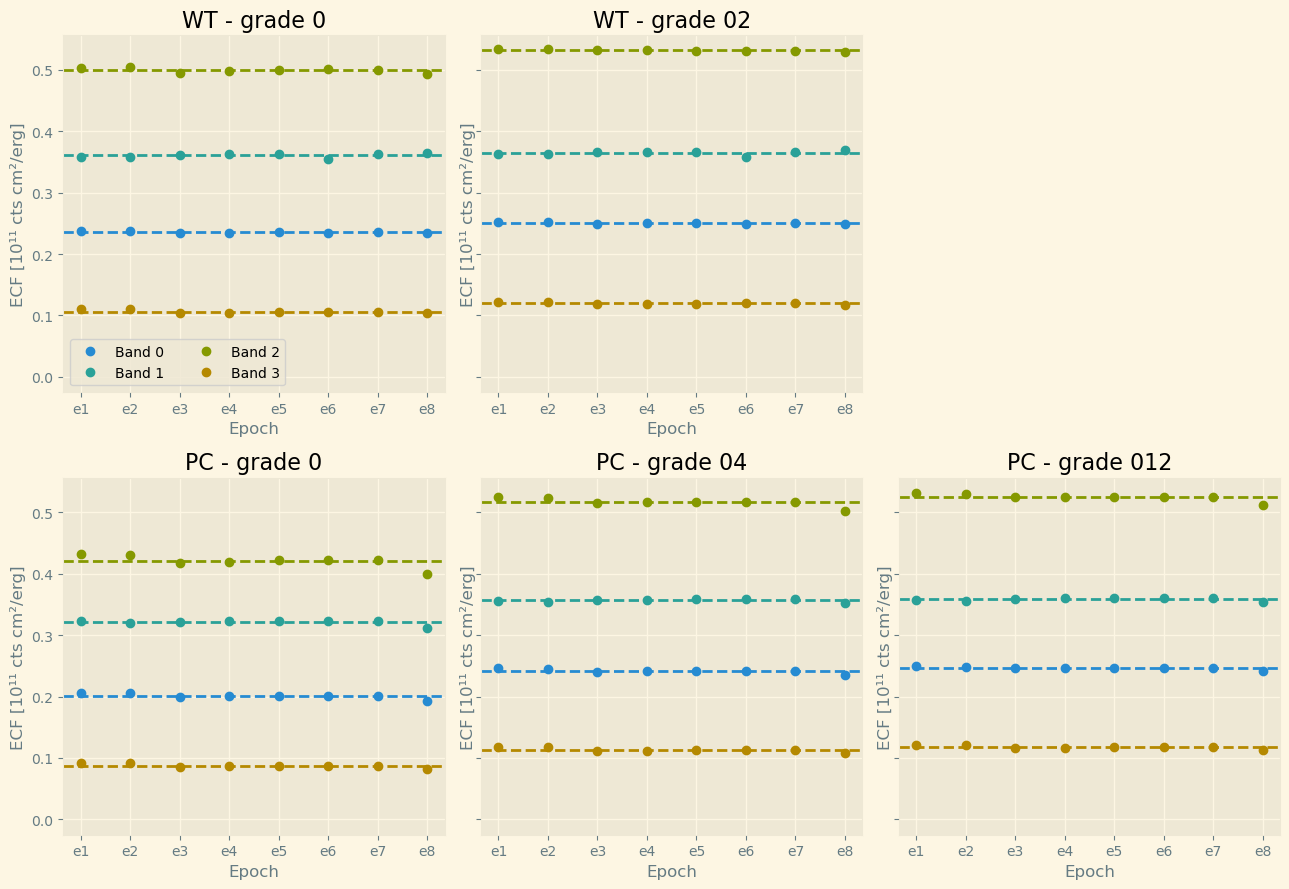

In [61]:
idx_lognh = 15  # ~3e20
idx_gamma = 3   # 1.7


fig, axes = plt.subplots(2, 3, figsize=(13,9), sharey=True)

ax = None
for i, mode in enumerate(modes):
    if mode == "wt":
        grades = wt_grades
    else:
        grades = pc_grades
    
    for j, grade in enumerate(grades):
        axes[i, j].set_title(f"{mode.upper()} - grade {grade}")
    
        for eband in range(4):
            cecf = [abscorr_ecf[mode][epoch][grade][eband][idx_lognh][idx_gamma] for epoch in epochs]
            vals, = axes[i, j].plot(epochs.keys(), cecf, "o", label=f"Band {eband}")
            axes[i, j].axhline(np.mean(cecf), ls="--", color=vals.get_color())
    
            # max_diff = np.max(cecf) - np.min(cecf)
            # print(mode, eband, 100*np.std(cecf)/np.mean(cecf), 100*max_diff/np.mean(cecf))
    
        axes[i, j].set_xlabel("Epoch")
        axes[i, j].set_ylabel("ECF [10¹¹ cts cm²/erg]")

axes[0, 0].legend(ncol=2)
axes[0, 0].set_ylim(-0.025)
axes[0, 2].set_axis_off()

plt.tight_layout()
plt.show()

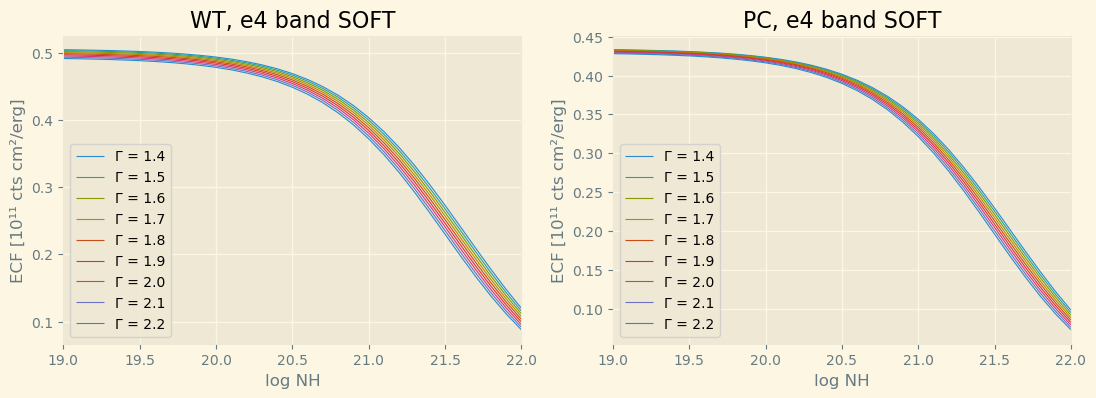

In [62]:
band = "SOFT"

plt.figure(figsize=(13,4))

plt.subplot(121)
plt.title(f"WT, e4 band {band}")

for i, gamma in enumerate(ecf["gamma"]):
    cecf = [abscorr_ecf["wt"]["e4"]["0"][band][idx_lognh][i] for idx_lognh, _ in enumerate(abscorr_ecf["lognh"])]
    plt.plot(abscorr_ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")

plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")


plt.subplot(122)
plt.title(f"PC, e4 band {band}")

for i, gamma in enumerate(ecf["gamma"]):
    cecf = [abscorr_ecf["pc"]["e4"]["0"][band][idx_lognh][i] for idx_lognh, _ in enumerate(abscorr_ecf["lognh"])]
    plt.plot(abscorr_ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")

plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")

plt.show()